In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import os
import faiss
import time
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
import cv2
from attention_unet import Attention_block, conv_block, up_conv
import matplotlib.pyplot as plt
from dataloaders import OneImageDataset

In [2]:
import albumentations as A

In [3]:
dataset_path = Path('/home/e_radionova/Datasets/Caltech_birds/CUB_200_2011/dataset/train')

### 1. Create dataset

In [4]:
transform = A.Compose([
    A.CenterCrop(width=400, height=288),
])

In [6]:
# trans = transforms.Compose([
#     transforms.Resize((288, 400), interpolation=Image.NEAREST),
#     transforms.ToTensor(),
# ])

train_set = OneImageDataset(images_folder = dataset_path / 'images/001.Black_footed_Albatross/',
                            masks_folder = dataset_path / 'masks/001.Black_footed_Albatross/',
                            idx=2,
                            img_transform=transform)

Text(0.5, 1.0, 'Black_Footed_Albatross_0010_796097.jpg')

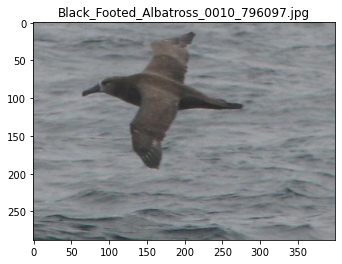

In [7]:
batch_size=1
dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
}

inputs = next(iter(dataloaders['train']))

# dataloaders['train'].dataset.images_names

plt.imshow(inputs[0].permute(1,2,0))
plt.title(dataloaders['train'].dataset.images_names[0])

### 2. Create and run model

In [8]:
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

In [9]:
from test_model import TestModel

in_channels = 3
model = TestModel(in_channels)
output = model(inputs)

In [10]:
# imgs_count = output.shape[1]
# fig, ax = plt.subplots(imgs_count//4, 4, figsize=(20, 100))
# for i in range(imgs_count):
#     ax[i//4, i%4].imshow(output.detach().numpy()[0][i:i+1,:,:].transpose(1, 2, 0))
#     ax[i//4, i%4].set_title(f'Layer {i}')

### 3. Choose feature map

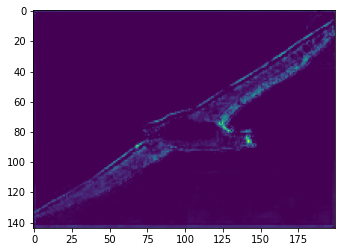

In [10]:
i=50
fm = output.detach().numpy()[0][i:i+1,:,:].transpose(1, 2, 0)
plt.imshow(fm)

### 4. Get template by thresholding

(144, 200, 1)
avg: 0.6647708
max: 8.433367


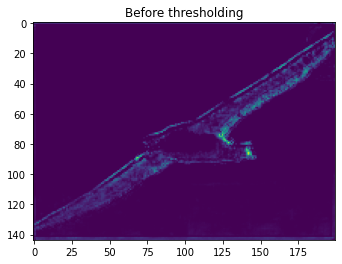

avg: 4.2166834
max: 8.433367


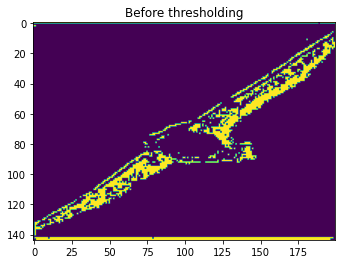

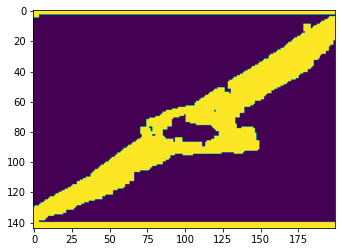

In [11]:
from template_matching_funcs import thresholding

print(fm.shape)
fm_thresh = thresholding(fm, 1.0)
fm_thresh = thresholding(fm_thresh, 1.0, otsu=True)
kern = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
fm_thresh = cv2.morphologyEx(fm_thresh, cv2.MORPH_CLOSE, kern)
fm_thresh = cv2.dilate(fm_thresh,kern,iterations = 1)
plt.imshow(fm_thresh)

#### Template matching example 

In [12]:
from template_matching_funcs import template_matching

img = cv2.imread(str(dataset_path / 'images/001.Black_footed_Albatross/' / dataloaders['train'].dataset.images_names[0]))
result_matchimg = template_matching(img, 
                                    fm_thresh)

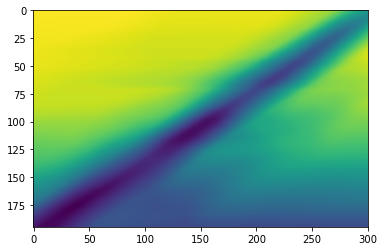

In [13]:
plt.imshow(result_matchimg)

### 5. To get kernel

In [14]:
from template_matching_funcs import template_matching, thresholding, get_Fourier_coeffs_and_kernel

def get_kernel_baseline(image, template, order, kernel_size,
                       morph_open, morph_close, dilate):
#     img_match = template_matching(image=image, template=template, method=cv2.TM_CCORR)
    img_thresh = thresholding(template, 1.0, otsu=True)
    
#     r = cv2.selectROI(img_thresh)
#     imCrop = img_thresh[int(r[1]):int(r[1]+r[3]), int(r[0]):int(r[0]+r[2])]
#     plt.imshow(imCrop)
#     plt.show()
    
    kern = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))  # np.ones((5,5),np.uint8)
    if morph_open:
        img_thresh = cv2.morphologyEx(img_thresh, cv2.MORPH_OPEN, kern)
    if morph_close:
        img_thresh = cv2.morphologyEx(img_thresh, cv2.MORPH_CLOSE, kern)
    if dilate:
        img_thresh = cv2.dilate(img_thresh,kern,iterations = 1)
    
    img_thresh = 255 * abs(img_thresh / img_thresh.max())
#     img_thresh = np.array(img_thresh, np.uint8)
    print(np.unique(img_thresh))
    plt.imshow(img_thresh, cmap='gray')
    plt.title('Image after thresholfing')
    plt.show()
    _, kernel = get_Fourier_coeffs_and_kernel(img_thresh, order=order, kernel_size=kernel_size)
    
    return kernel, img_thresh

avg: 4.0
max: 8


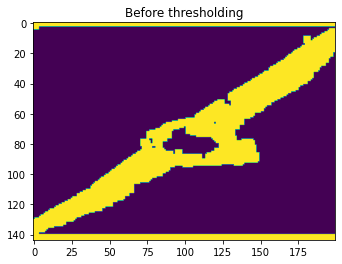

[  0. 255.]


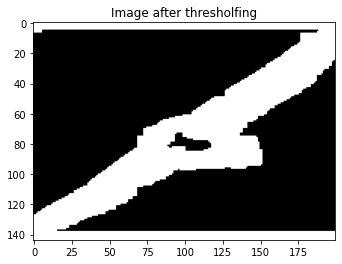

In [15]:
kernel_per_img, img_thresh = get_kernel_baseline(image=img, 
                                                 template=fm_thresh, 
                                                 order=10, 
                                                 kernel_size=20,
                                                 morph_open=False, 
                                                 morph_close=False, 
                                                 dilate=True)

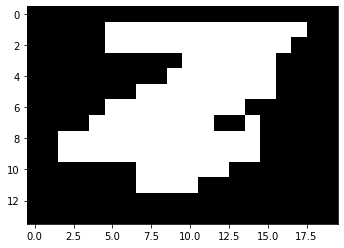

In [18]:
plt.imshow(kernel_per_img)

In [21]:
np.unique(kernel_per_img)

array([0., 1.])

### Pre-trained detection

In [11]:
import sys
sys.path.insert(1, '/home/e_radionova/a-PyTorch-Tutorial-to-Object-Detection')

In [12]:
from detect import detect


Loaded checkpoint from epoch 232.



/home/e_radionova/anaconda3/lib/python3.8/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/e_radionova/anaconda3/lib/python3.8/site-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.pooling.MaxPool2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [13]:
path = str(dataset_path / 'images/001.Black_footed_Albatross/' / dataloaders['train'].dataset.images_names[0])
detect_img = Image.open(path).convert('RGB')

In [ ]:
im = Image.fromarray(img_thresh)

/home/e_radionova/a-PyTorch-Tutorial-to-Object-Detection/model.py:501: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  image_boxes.append(class_decoded_locs[1 - suppress])
/home/e_radionova/a-PyTorch-Tutorial-to-Object-Detection/model.py:503: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
  image_scores.append(class_scores[1 - suppress])


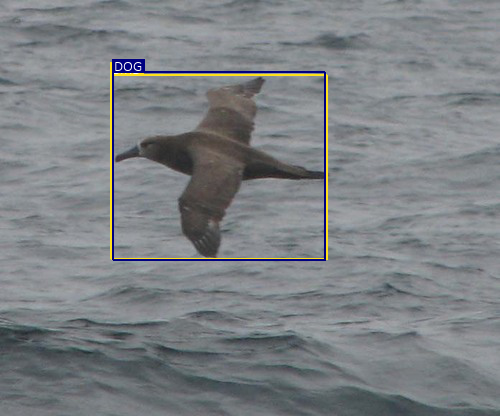

In [14]:
# detect(original_image=im.convert('RGB'), min_score=0.2, max_overlap=0.5, top_k=200)
detect(original_image=detect_img, min_score=0.2, max_overlap=0.5, top_k=200)

In [36]:
np.array(detect_img).shape

(338, 500, 3)